In [37]:
import hashlib
import os
import tarfile
import zipfile
import requests

#@save
DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

In [38]:
def download(name, cache_dir=os.path.join('..', 'data')):  #@save
    """下载一个DATA_HUB中的文件，返回本地文件名"""
    assert name in DATA_HUB, f"{name} not in {DATA_HUB}"
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname
    print(f"downloading {fname} from {url}...")
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname


In [39]:
def download_extract(name, folder=None):  #@save
    """下载并解压zip/tar文件"""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, "only zip/tar file can be extracted"
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir


def download_all():  #@save
    """下载并解压zip/tar文件"""
    for name in DATA_HUB:
        download(name)

In [40]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

In [41]:
DATA_HUB['kaggle_house_train'] = (  #@save
    DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce')

DATA_HUB['kaggle_house_test'] = (  #@save
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

In [42]:
train_data = pd.read_csv(download('kaggle_house_train'))
test_data = pd.read_csv(download('kaggle_house_test'))

In [43]:
print(train_data.shape)
print(test_data.shape)

(1460, 81)
(1459, 80)


In [44]:
print(train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]])

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


In [45]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

In [46]:
all_features

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
1455,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
1456,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
1457,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal


In [47]:
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std())
)
all_features[numeric_features] = all_features[numeric_features].fillna(0.)

In [48]:
all_features

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,0.067320,RL,-0.184443,-0.217841,Pave,NaN,Reg,Lvl,AllPub,Inside,...,-0.285886,-0.063139,NaN,NaN,NaN,-0.089577,-1.551918,0.157619,WD,Normal
1,-0.873466,RL,0.458096,-0.072032,Pave,NaN,Reg,Lvl,AllPub,FR2,...,-0.285886,-0.063139,NaN,NaN,NaN,-0.089577,-0.446848,-0.602858,WD,Normal
2,0.067320,RL,-0.055935,0.137173,Pave,NaN,IR1,Lvl,AllPub,Inside,...,-0.285886,-0.063139,NaN,NaN,NaN,-0.089577,1.026577,0.157619,WD,Normal
3,0.302516,RL,-0.398622,-0.078371,Pave,NaN,IR1,Lvl,AllPub,Corner,...,-0.285886,-0.063139,NaN,NaN,NaN,-0.089577,-1.551918,-1.363335,WD,Abnorml
4,0.067320,RL,0.629439,0.518814,Pave,NaN,IR1,Lvl,AllPub,FR2,...,-0.285886,-0.063139,NaN,NaN,NaN,-0.089577,2.131647,0.157619,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2.419286,RM,-2.069222,-1.043758,Pave,NaN,Reg,Lvl,AllPub,Inside,...,-0.285886,-0.063139,NaN,NaN,NaN,-0.089577,-0.078492,-1.363335,WD,Normal
1455,2.419286,RM,-2.069222,-1.049083,Pave,NaN,Reg,Lvl,AllPub,Inside,...,-0.285886,-0.063139,NaN,NaN,NaN,-0.089577,-0.815205,-1.363335,WD,Abnorml
1456,-0.873466,RL,3.884968,1.246594,Pave,NaN,Reg,Lvl,AllPub,Inside,...,-0.285886,-0.063139,NaN,NaN,NaN,-0.089577,1.026577,-1.363335,WD,Abnorml
1457,0.655311,RL,-0.312950,0.034599,Pave,NaN,Reg,Lvl,AllPub,Inside,...,-0.285886,-0.063139,NaN,MnPrv,Shed,1.144116,0.289865,-1.363335,WD,Normal


In [49]:
all_features = pd.get_dummies(all_features, dummy_na=True)

In [50]:
all_features

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_Oth,SaleType_WD,SaleType_nan,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SaleCondition_nan
0,0.067320,-0.184443,-0.217841,0.646073,-0.507197,1.046078,0.896679,0.523038,0.580708,-0.29303,...,0,1,0,0,0,0,0,1,0,0
1,-0.873466,0.458096,-0.072032,-0.063174,2.187904,0.154737,-0.395536,-0.569893,1.177709,-0.29303,...,0,1,0,0,0,0,0,1,0,0
2,0.067320,-0.055935,0.137173,0.646073,-0.507197,0.980053,0.848819,0.333448,0.097840,-0.29303,...,0,1,0,0,0,0,0,1,0,0
3,0.302516,-0.398622,-0.078371,0.646073,-0.507197,-1.859033,-0.682695,-0.569893,-0.494771,-0.29303,...,0,1,0,1,0,0,0,0,0,0
4,0.067320,0.629439,0.518814,1.355319,-0.507197,0.947040,0.753100,1.381770,0.468770,-0.29303,...,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2.419286,-2.069222,-1.043758,-1.481667,1.289537,-0.043338,-0.682695,-0.569893,-0.968860,-0.29303,...,0,1,0,0,0,0,0,1,0,0
1455,2.419286,-2.069222,-1.049083,-1.481667,-0.507197,-0.043338,-0.682695,-0.569893,-0.415757,-0.29303,...,0,1,0,1,0,0,0,0,0,0
1456,-0.873466,3.884968,1.246594,-0.772420,1.289537,-0.373465,0.561660,-0.569893,1.717643,-0.29303,...,0,1,0,1,0,0,0,0,0,0
1457,0.655311,-0.312950,0.034599,-0.772420,-0.507197,0.682939,0.370221,-0.569893,-0.229194,-0.29303,...,0,1,0,0,0,0,0,1,0,0


In [51]:
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)
train_labels = torch.tensor(train_data.SalePrice.values.reshape(-1, 1), dtype=torch.float32)

In [52]:
print(train_features)
print(train_features.shape)
print(test_features)
print(test_features.shape)

tensor([[ 0.0673, -0.1844, -0.2178,  ...,  1.0000,  0.0000,  0.0000],
        [-0.8735,  0.4581, -0.0720,  ...,  1.0000,  0.0000,  0.0000],
        [ 0.0673, -0.0559,  0.1372,  ...,  1.0000,  0.0000,  0.0000],
        ...,
        [ 0.3025, -0.1416, -0.1428,  ...,  1.0000,  0.0000,  0.0000],
        [-0.8735, -0.0559, -0.0572,  ...,  1.0000,  0.0000,  0.0000],
        [-0.8735,  0.2439, -0.0293,  ...,  1.0000,  0.0000,  0.0000]])
torch.Size([1460, 331])
tensor([[-0.8735,  0.4581,  0.1843,  ...,  1.0000,  0.0000,  0.0000],
        [-0.8735,  0.5009,  0.5197,  ...,  1.0000,  0.0000,  0.0000],
        [ 0.0673,  0.2011,  0.4643,  ...,  1.0000,  0.0000,  0.0000],
        ...,
        [-0.8735,  3.8850,  1.2466,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.6553, -0.3130,  0.0346,  ...,  1.0000,  0.0000,  0.0000],
        [ 0.0673,  0.2011, -0.0686,  ...,  1.0000,  0.0000,  0.0000]])
torch.Size([1459, 331])


In [53]:
loss = nn.MSELoss()
in_features = train_features.shape[1]


def get_net():
    net = nn.Sequential(nn.Linear(in_features, 1))
    return net

In [54]:
def log_rmse(net, features, labels):
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds), torch.log(labels)))
    return rmse.item()

In [55]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], [],
    train_iter = d2l.load_array((train_features, train_labels), batch_size)

    optimizer = torch.optim.Adam(net.parameters(),
                                 lr=learning_rate,
                                 weight_decay=weight_decay)

    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))

    return train_ls, test_ls

In [56]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        indx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[indx, :], y[indx],
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid


In [57]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay, batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate, weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        print(f'fold {i + 1}, train log rmse {float(train_ls[-1]):f}, ')
        print(f'valid log rmse {float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

fold 1, train log rmse 0.134262, 
valid log rmse 0.151887
fold 2, train log rmse 0.135005, 
valid log rmse 0.118515
fold 3, train log rmse 0.135962, 
valid log rmse 0.130734
fold 4, train log rmse 0.131349, 
valid log rmse 0.161043
fold 5, train log rmse 0.129877, 
valid log rmse 0.162521
fold 6, train log rmse 0.135329, 
valid log rmse 0.117394
fold 7, train log rmse 0.135970, 
valid log rmse 0.129449
fold 8, train log rmse 0.134516, 
valid log rmse 0.143436
fold 9, train log rmse 0.129034, 
valid log rmse 0.190013
fold 10, train log rmse 0.134579, 
valid log rmse 0.139311
10 fold validation: mean training log rmse: 0.133588, 
mean validation log rmse: 0.144430


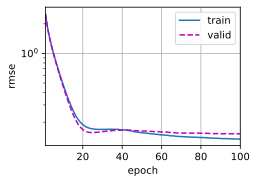

In [62]:
k, num_epochs, lr, weight_decay, batch_size = 10, 100, 15, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr, weight_decay, batch_size)

print(f'{k} fold validation: mean training log rmse: {float(train_l):f}, ')
print(f'mean validation log rmse: {float(valid_l):f}')

In [65]:
def train_and_pred(train_features, test_features, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None, num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch', ylabel='log rmse', xlim=[1, num_epochs],
             yscale='log')
    print(f'train log rmse: {float(train_ls[-1]):f}')

    preds = net(test_features).detach().numpy()

    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)

train log rmse: 0.132229


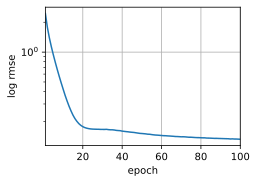

In [66]:
train_and_pred(train_features, test_features, train_labels, test_data, num_epochs, lr, weight_decay, batch_size)